# Regression-Analysis-of-COVID-19

The objective of this project is to study the COVID-19 outbreak using basic visualization techniques and regression. The active and closed cases were compared and the growth factor was calculated to observe the change in growth rate. Short term predictions were performed in order to study the impact and spread of the COVID-19 in coming days.

** Regression Methods can be used:**
* Linear regression
* Polynomial Regression
* Ridge regression
* Polynomial Ridge regression
* SVM
* Decision tree

In [ ]:
# IMPORTING ALL THE LIBRARY
import os
import pandas as pd;
import numpy  as np;
import scipy.integrate;
import matplotlib.pyplot as plt;
import copy;
from sklearn.metrics       import mean_squared_error, mean_absolute_error;
from sklearn.linear_model  import LinearRegression, BayesianRidge;
from sklearn.tree          import DecisionTreeRegressor;
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV;

## 1. Read Data, clean NA value and remove bad line

In [ ]:
data = pd.read_csv("/content/covid_19_data.csv", header=0, na_values= ['',' ','NA','na','Na','N/A','N/a','n/a'], error_bad_lines = False)

<ipython-input-2-ba77550b361b>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_orig = pd.read_csv("/content/covid_19_data.csv", header=0, na_values= ['',' ','NA','na','Na','N/A','N/a','n/a'], error_bad_lines = False)


In [ ]:
data.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


## 2. **new dataframe** which counts the **cumulative total**         number of cases, the cumulative total number of deaths, and also          cumulative total number of recoveries for each date.

In [ ]:
df = copy.deepcopy(data);
del df['Last Update'];
date_lst  = df.ObservationDate.unique();
date_dict = {}
#len(date_lst) # 70 dates
for i in range(len(date_lst)):
    df_temp = df.loc[df['ObservationDate'] == date_lst[i]];
    date_dict[date_lst[i]] = df_temp;
# print(date_dict)

In [ ]:
date_tot_tup_dict = {};
for date, df in date_dict.items():
    tup_temp = (df['Confirmed'].sum(), df['Deaths'].sum(), df['Recovered'].sum())
    date_tot_tup_dict[date] = tup_temp;
#print(date_tot_tup_dict);

In [ ]:
df_date_tots = pd.DataFrame(date_tot_tup_dict);
df_date_tots = df_date_tots.transpose();
df_date_tots.columns = ['Confirmed', 'Deaths', 'Recovered'];
print(df_date_tots)

            Confirmed   Deaths  Recovered
01/22/2020      555.0     17.0       28.0
01/23/2020      653.0     18.0       30.0
01/24/2020      941.0     26.0       36.0
01/25/2020     1438.0     42.0       39.0
01/26/2020     2118.0     56.0       52.0
...               ...      ...        ...
03/27/2020   593291.0  27198.0   130915.0
03/28/2020   660706.0  30652.0   139415.0
03/29/2020   720117.0  33925.0   149082.0
03/30/2020   782365.0  37582.0   164566.0
03/31/2020   857487.0  42107.0   178034.0

[70 rows x 3 columns]


## 3. **Plot** the total number of cases per day over time and summarize your findings

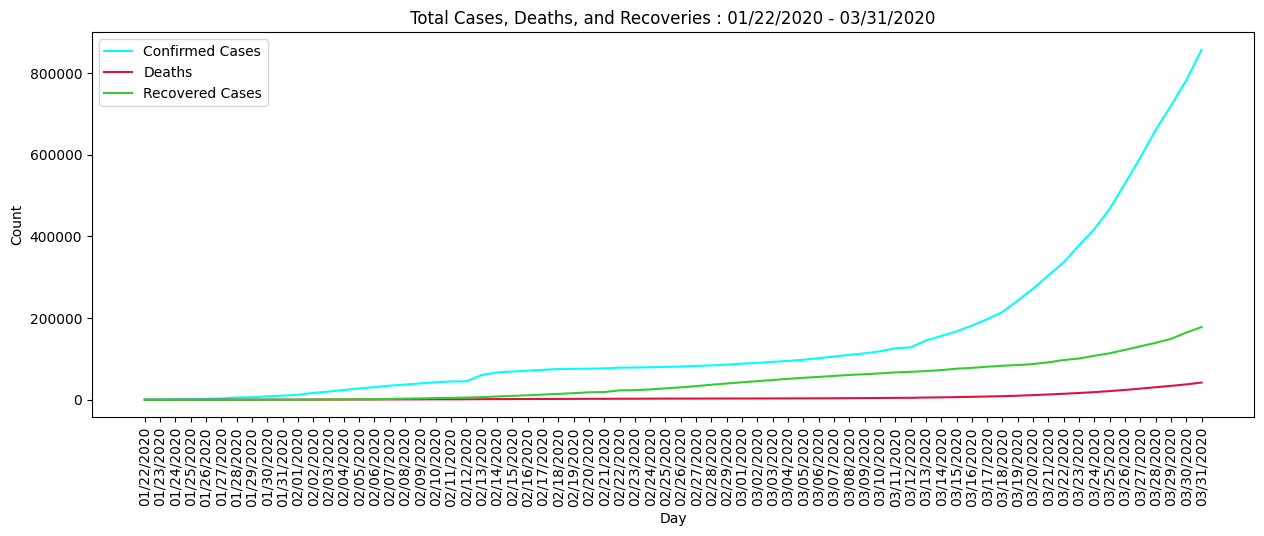

In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);
plt.plot(df_date_tots['Confirmed'], label = "Confirmed Cases", color = 'cyan')
plt.plot(df_date_tots['Deaths'], label    = "Deaths", color = 'crimson')
plt.plot(df_date_tots['Recovered'], label = "Recovered Cases", color = 'limegreen')
#plt.grid();
plt.legend();
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Total Cases, Deaths, and Recoveries : " + start_date + " - " + fin_date);


All of the three curves seem to be exponential (start of logistic curve). The confirmed cases was obviously higher than the deaths and recovered cases. The rate of the the recovered cases seems to be higher than that of the death curve.

## 4. Create a new column in the dataframe called **“closed cases”**

In [ ]:
df_date_tots['Closed Cases'] = df_date_tots['Deaths'] + df_date_tots['Recovered'];
#print(df_date_tots)

## 5. Create a new column in the dataframe called “active cases”

In [ ]:
df_date_tots['Active Cases'] = df_date_tots['Confirmed'] - df_date_tots['Closed Cases']

## 6. Create one **plot** showing the trend of number of active cases and closed cases

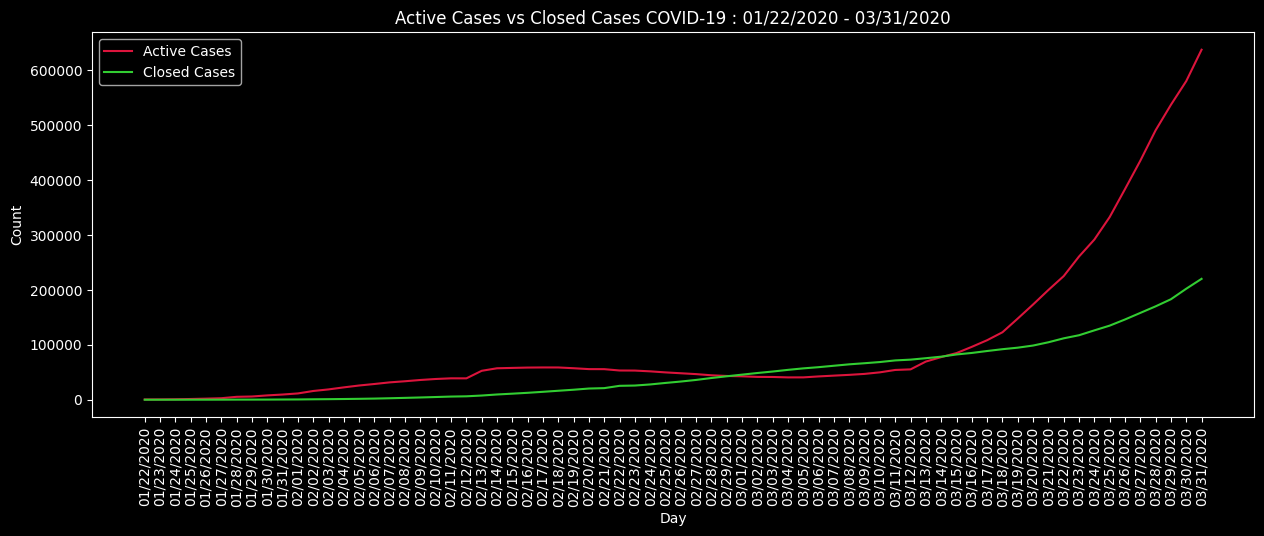

In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);
plt.plot(df_date_tots['Active Cases'], label = "Active Cases", color = 'crimson')
plt.plot(df_date_tots['Closed Cases'], label = "Closed Cases", color = 'limegreen')
#plt.grid();
plt.legend();
plt.xlabel("Day")
plt.ylabel("Count")
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Active Cases vs Closed Cases COVID-19 : " + start_date + " - " + fin_date);

## 7. Growth Factor

In [ ]:
growth_len_lst = len(date_lst) - 1; # 69
confirmed_lst = df_date_tots["Confirmed"];
death_lst = df_date_tots["Deaths"];
recovered_lst = df_date_tots["Recovered"];
confGF_lst = []
deathsGF_lst = []
recovGF_lst = []
for i in range(growth_len_lst):
    confirmedGF = confirmed_lst[i+1] / confirmed_lst[i] ;
    confGF_lst.append(confirmedGF)
    deathGF = death_lst[i+1] / death_lst[i] ;
    deathsGF_lst.append(deathGF)
    recoveredGF = recovered_lst[i+1] / recovered_lst[i] ;
    recovGF_lst.append(recoveredGF);


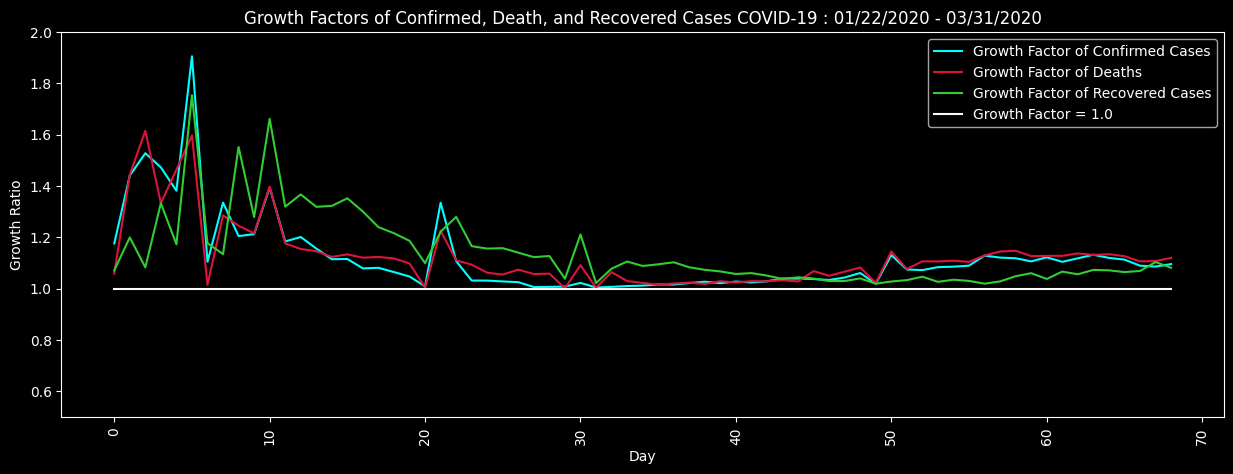

In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);
plt.plot(confGF_lst, label = "Growth Factor of Confirmed Cases", color = 'cyan')
plt.plot(deathsGF_lst, label = "Growth Factor of Deaths", color = 'crimson')
plt.plot(recovGF_lst, label = "Growth Factor of Recovered Cases", color = 'limegreen')
x = []
for i in range((growth_len_lst)):
    x.append(1);
plt.plot(x, label = "Growth Factor = 1.0", color = 'snow')
#plt.grid();
plt.legend();
plt.xlabel("Day")
plt.ylabel("Growth Ratio")
plt.ylim(.5,2)
plt.xticks(rotation = 90);
start_date = str(date_lst[0]);
fin_date   = str(date_lst[len(date_lst) -1])
plt.title("Growth Factors of Confirmed, Death, and Recovered Cases COVID-19 : " +
          start_date +
          " - " +
          fin_date);

# Prediction Using Linear Regression

### To make our data to be compatible with *sklearn* format, create a new column called “Days since” which tracks the number of days since the initial date.

In [ ]:
days_since_lst = [];
for i in range(len(date_lst)):
    days_since_lst.append(i);
df_date_tots["Days Since:"] = days_since_lst;
df_date_tots = df_date_tots[["Days Since:", "Confirmed", "Deaths", "Recovered", "Active Cases", "Closed Cases"]];
#print(df_date_tots)

## 8. Take the earliest 85% of the dates as **train** and the rest as **test**

In [ ]:
#df_date_tots_cp = copy.deepcopy(df_date_tots);
#X = df_date_tots_cp.drop("Days Since:", axis = 1)

# -----------------------------------------------------------------
X = np.array(df_date_tots["Confirmed"])#.reshape(-1,1)
# X is the world cases array
y = np.array(df_date_tots["Days Since:"]).reshape(-1,1)
# y is the day count array associated with the world cases array
# -----------------------------------------------------------------


#len_train = (len(date_lst)*85)//100;
#len_test  = (len(date_lst) - len_train)

#X_train   =  X.iloc[:len_train];
#X_train = pd.Series(X_train)
#scaler = StandardScaler()
#X_train = scaler.fit_transform(pd.DataFrame(X_train))

#y_train   =  y.iloc[:len_train];
#y_train = pd.Series(y_train)
#scaler = StandardScaler()
#y_train = scaler.fit_transform(pd.DataFrame(y_train))


#X_test    =  X.iloc[len_train-1:];
#X_test = pd.Series(X_test)
#scaler = StandardScaler()
#X_test = scaler.fit_transform(pd.DataFrame(X_test))

#y_test    =  y.iloc[len_train-1:];
#y_test = pd.Series(y_test)
#scaler = StandardScaler()
#y_test = scaler.fit_transform(pd.DataFrame(y_test))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, shuffle = False)
# shuffle = False lets the data be split in order

## 9. Try various linear regression methods discussed in class such as linear regression, ridge regression, svm, and decision tree and plot the points and our fit line

### 9.1 Linear Regression

In [ ]:
lin_model = LinearRegression(fit_intercept = False);
lin_model.fit(y_train, X_train);
test_lin_pred = lin_model.predict(y_test)
lin_pred = lin_model.predict(y)

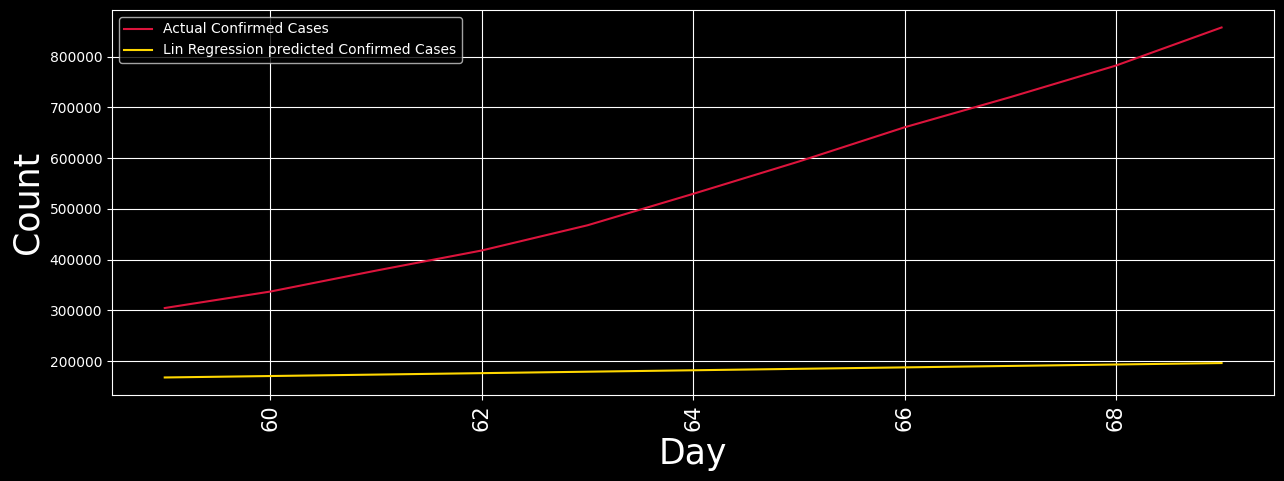

MAE: 368049.30417332525
MSE: 164288029427.18597


In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         test_lin_pred,
         label = "Lin Regression predicted Confirmed Cases",
         color = 'gold')
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (test_lin_pred, X_test))
print('MSE:', mean_squared_error  (test_lin_pred, X_test))

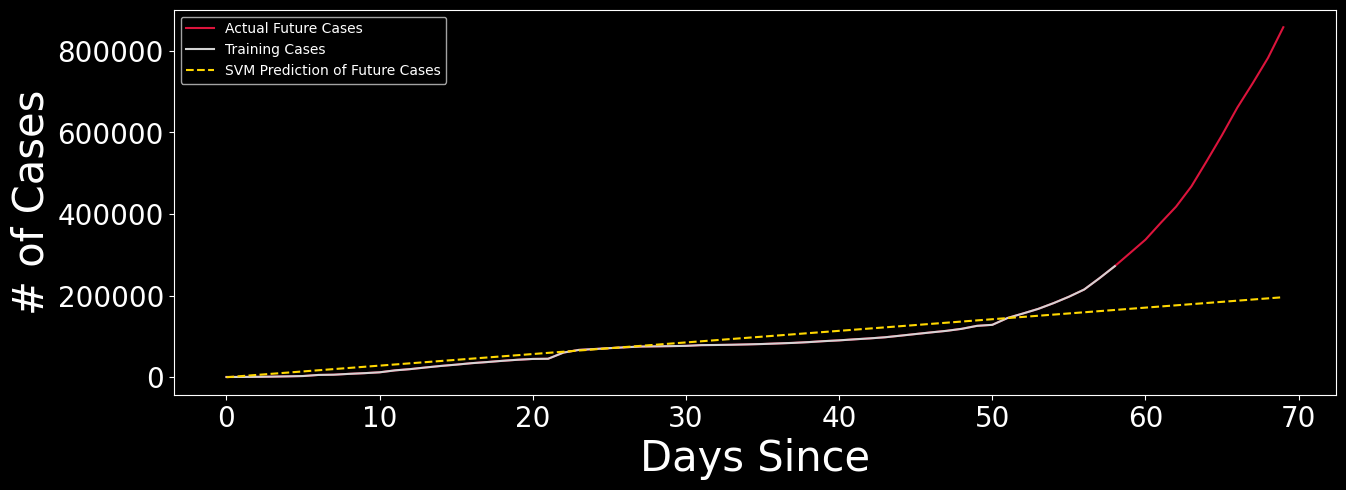

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')
plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')
plt.plot(y,
         lin_pred,
         label = 'SVM Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Polinomial Regression

In [ ]:
poly = PolynomialFeatures(degree=5)
poly_y_train = poly.fit_transform(y_train)
poly_y_test  = poly.fit_transform(y_test)
poly_y = poly.fit_transform(y)

In [ ]:
linear_model = LinearRegression(fit_intercept=False)
linear_model.fit(poly_y_train, X_train)
test_linear_pred = linear_model.predict(poly_y_test)
linear_pred = linear_model.predict(poly_y)


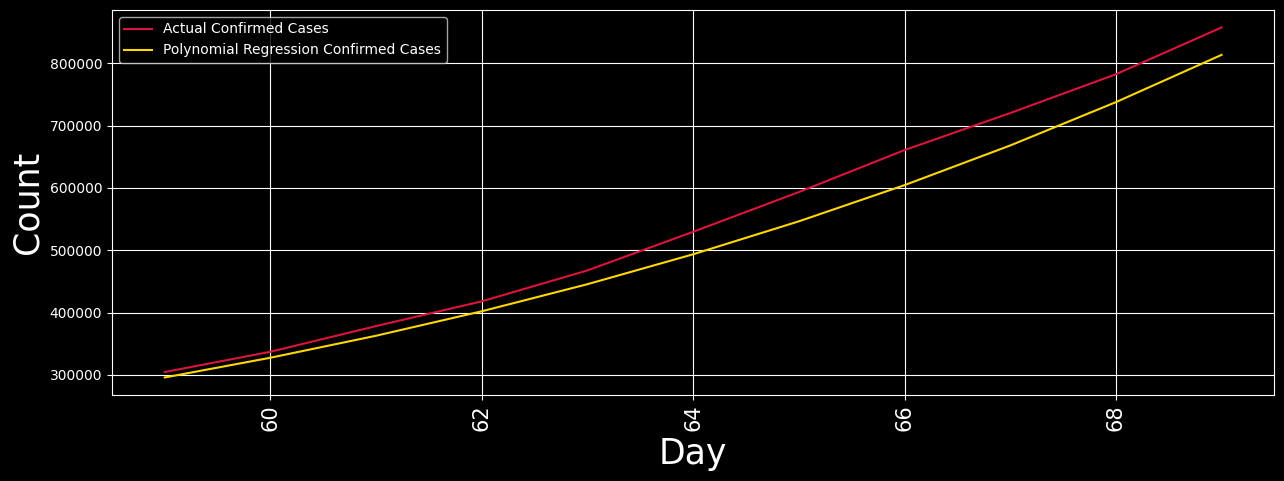

MAE: 31989.752428427022
MSE: 1314905574.5277777


In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         test_linear_pred,
         label = "Polynomial Regression Confirmed Cases",
         color = 'gold')
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(test_linear_pred, X_test))
print('MSE:',mean_squared_error(test_linear_pred, X_test))

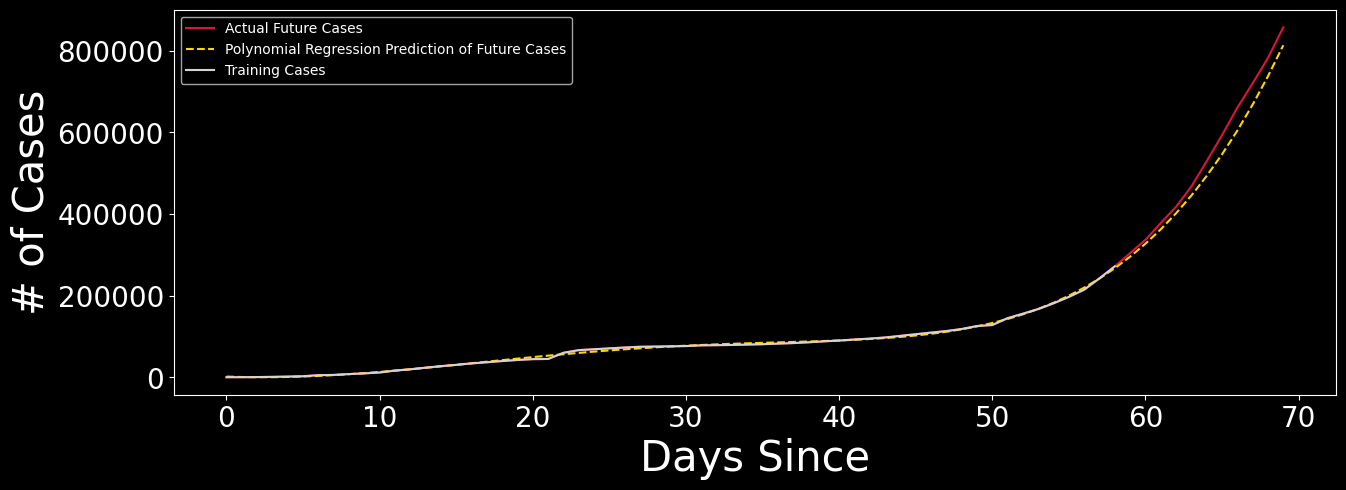

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')

plt.plot(y,
         linear_pred,
         label = 'Polynomial Regression Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')

plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 9.2 Ridge Regression

In [ ]:
tol      = [1e-4, 1e-3, 1e-2]
alpha_1  = [1e-7, 1e-6, 1e-5, 1e-4]
alpha_2  = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_1 = [1e-7, 1e-6, 1e-5, 1e-4]
lambda_2 = [1e-7, 1e-6, 1e-5, 1e-4]

bayesian_grid = {'tol': tol,
                 'alpha_1': alpha_1,
                 'alpha_2' : alpha_2,
                 'lambda_1': lambda_1,
                 'lambda_2' : lambda_2 }

bayesian = BayesianRidge(fit_intercept=False)
bayesian_search = RandomizedSearchCV(bayesian,
                                     bayesian_grid,
                                     scoring='neg_mean_squared_error',
                                     cv=3,
                                     return_train_score=True,
                                     n_jobs=-1,
                                     n_iter=40,
                                     verbose=1)

bayesian_search.fit(y_train, X_train);

print(bayesian_search.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.01, 'lambda_2': 0.0001, 'lambda_1': 0.0001, 'alpha_2': 0.0001, 'alpha_1': 1e-07}


In [ ]:
y_test_ridge_pred = bayesian_search.predict(y_test);
y_ridge_pred = bayesian_search.predict(y);

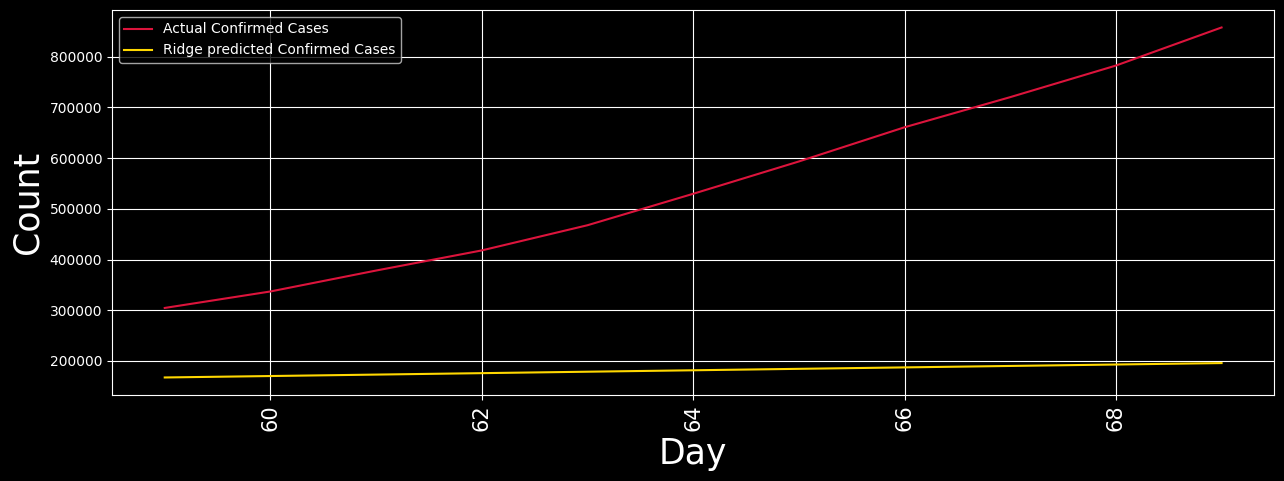

MAE: 368251.9660657689
MSE: 164440629513.7004


In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         y_test_ridge_pred,
         label = "Ridge predicted Confirmed Cases",
         color = 'gold')
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error (y_test_ridge_pred, X_test))
print('MSE:', mean_squared_error  (y_test_ridge_pred, X_test))

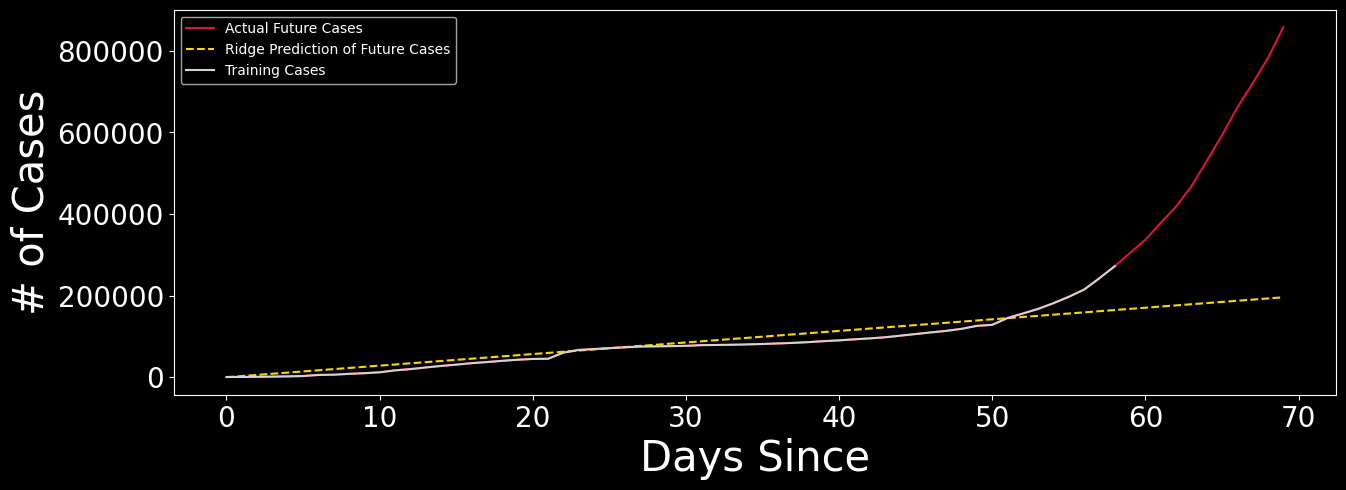

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')
plt.plot(y,
         y_ridge_pred,
         label = 'Ridge Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')
plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### Polinomial Ridge Regression

In [ ]:
bayesian_search_poly = RandomizedSearchCV(bayesian, bayesian_grid,scoring='neg_mean_squared_error', cv=3, return_train_score=True, n_jobs=-1, n_iter=40, verbose=1)


In [ ]:
bayesian_search_poly.fit(poly_y_train, X_train);
print(bayesian_search_poly.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
{'tol': 0.0001, 'lambda_2': 0.0001, 'lambda_1': 0.0001, 'alpha_2': 1e-07, 'alpha_1': 1e-06}


In [ ]:
bayesian_poly_confirmed = bayesian_search_poly.best_estimator_
test_poly_bayesian_pred = bayesian_poly_confirmed.predict(poly_y_test)
bayesian_poly_pred = bayesian_poly_confirmed.predict(poly_y)

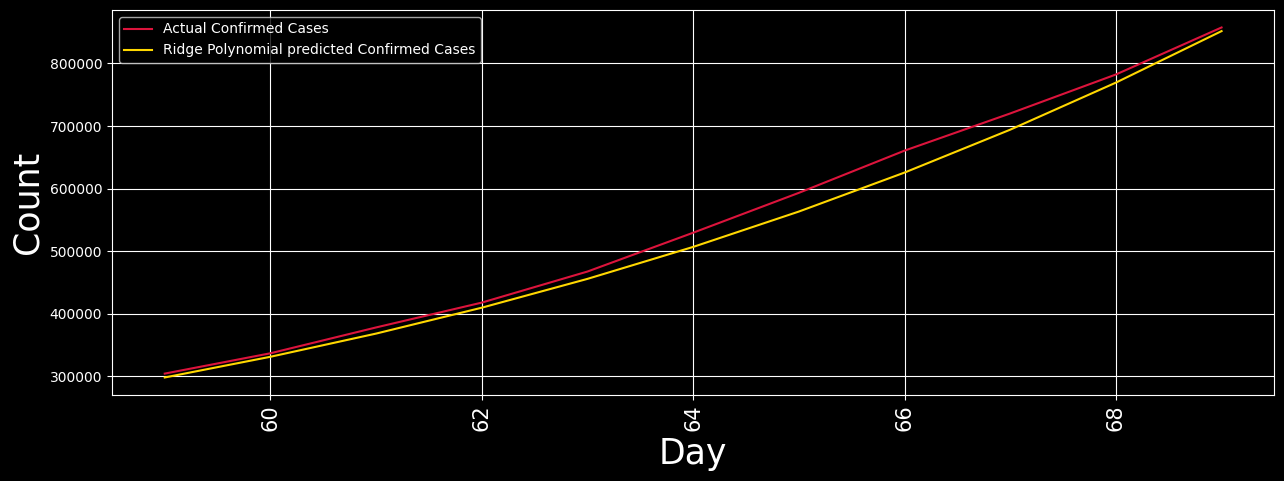

MAE: 15796.104528765141
MSE: 352565821.2177801


In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test, X_test, label = "Actual Confirmed Cases", color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test, test_poly_bayesian_pred, label = "Ridge Polynomial predicted Confirmed Cases", color = 'gold')
plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print ('MAE:', mean_absolute_error(test_poly_bayesian_pred, X_test))
print ('MSE:', mean_squared_error (test_poly_bayesian_pred, X_test))

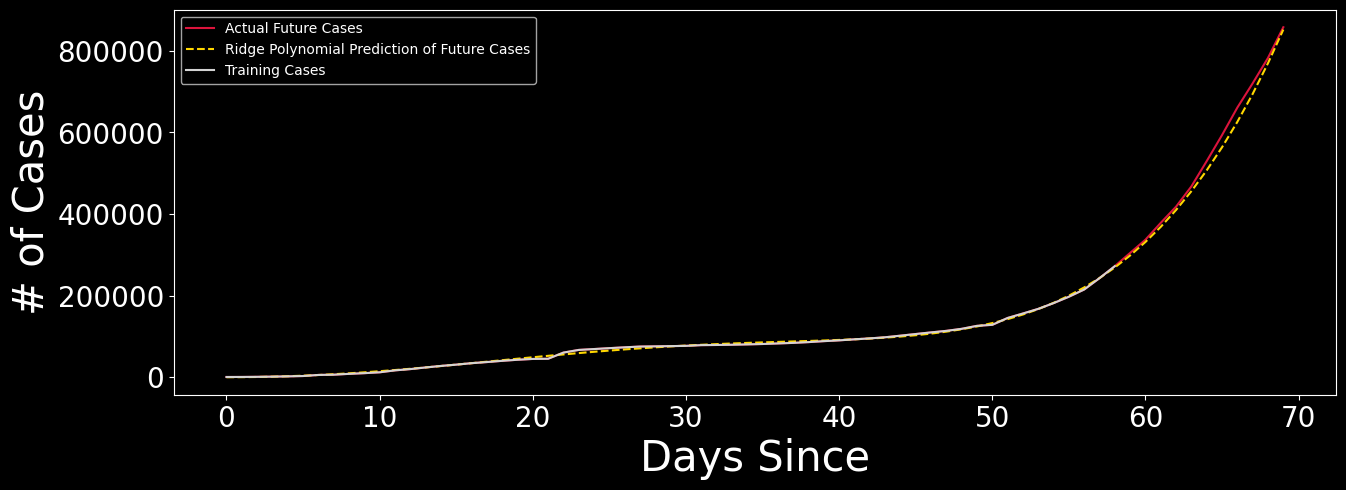

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')
plt.plot(y,
         bayesian_poly_pred,
         label = 'Ridge Polynomial Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')
plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)

#plt.grid()
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 9.3 SVM

In [ ]:
kernel = ['poly', 'sigmoid', 'rbf']
c = [0.01, 0.1, 1, 10, 100];
gamma = [0.01, 0.1, 1];
epsilon = [0.01, 0.1, 1];
shrinking = [True, False];
svm_grid = {'kernel' :kernel,
           'C' : c,
           'gamma':gamma,
           'epsilon': epsilon,
           'shrinking': shrinking}

svm = SVR();
svm_search = RandomizedSearchCV(svm, svm_grid, scoring = 'neg_mean_squared_error', cv=3,
                               return_train_score = True)


svm_search.fit(y_train, X_train) # note how y_train had to be put first
print(svm_search.best_params_)


{'shrinking': False, 'kernel': 'poly', 'gamma': 0.1, 'epsilon': 0.01, 'C': 0.01}


In [ ]:
y_pred_test = svm_search.predict(y_test)
# predict for the test days (future)

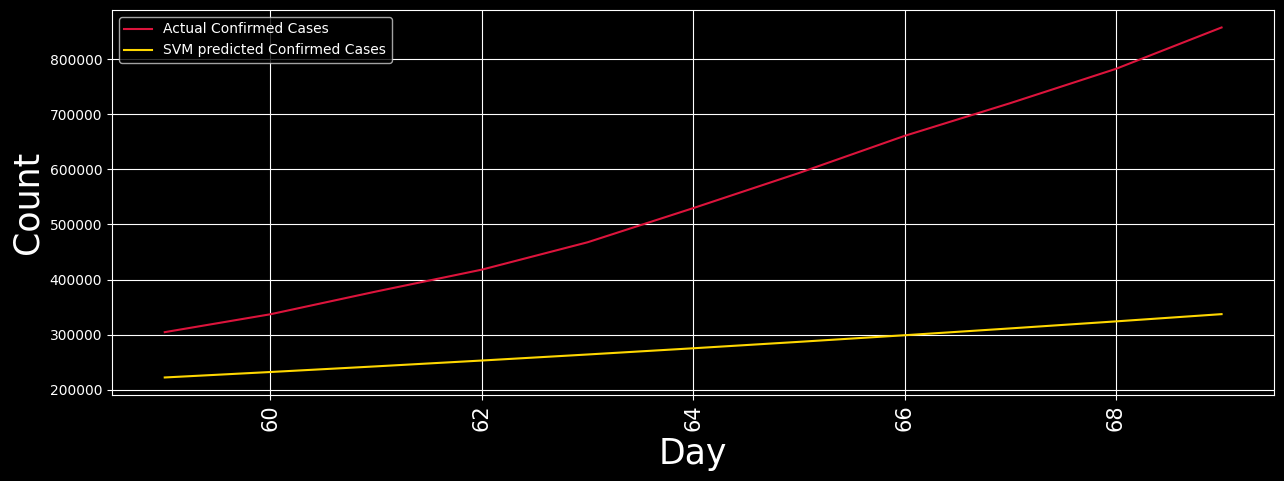

MAE: 272847.29527200613
MSE: 94739740390.64601


In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         y_pred_test,
         label = "SVM predicted Confirmed Cases",
         color = 'gold')

plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(y_pred_test, X_test))
print('MSE:',mean_squared_error(y_pred_test, X_test))

In [ ]:
#let's get a bigger picture
y_pred = svm_search.predict(y)

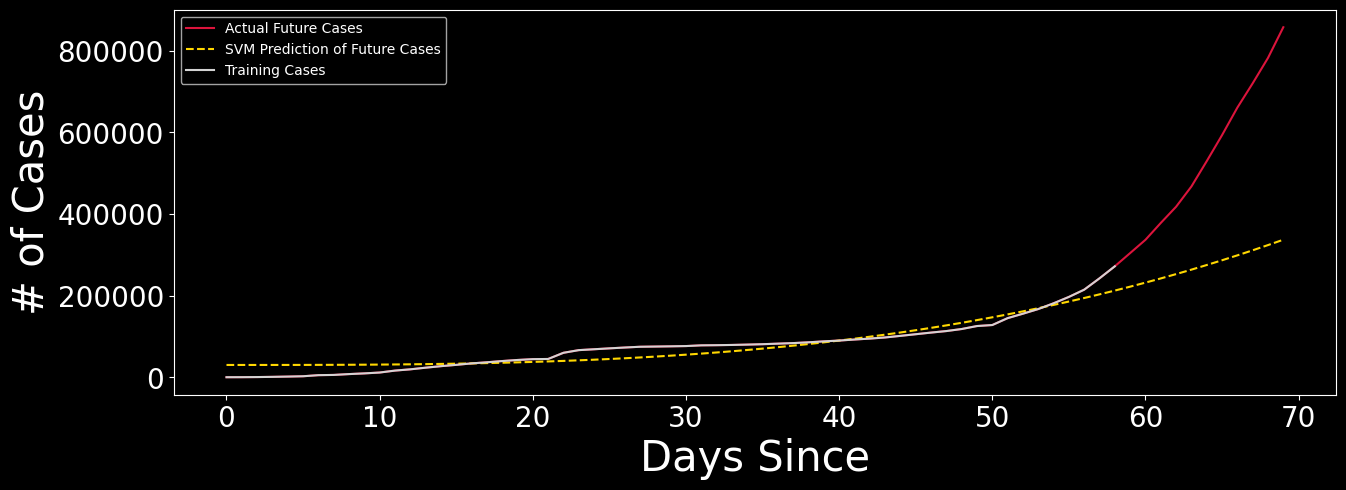

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')

plt.plot(y,
         y_pred,
         label = 'SVM Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')

plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')

plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

### 9.4 Decision Tree

In [ ]:
DT_reg = DecisionTreeRegressor(random_state=0);
DT_reg.fit(y_train, X_train);
y_test_DT_pred = DT_reg.predict(y_test);
y_DT_pred = DT_reg.predict(y);
#print(y_test_DT_pred)

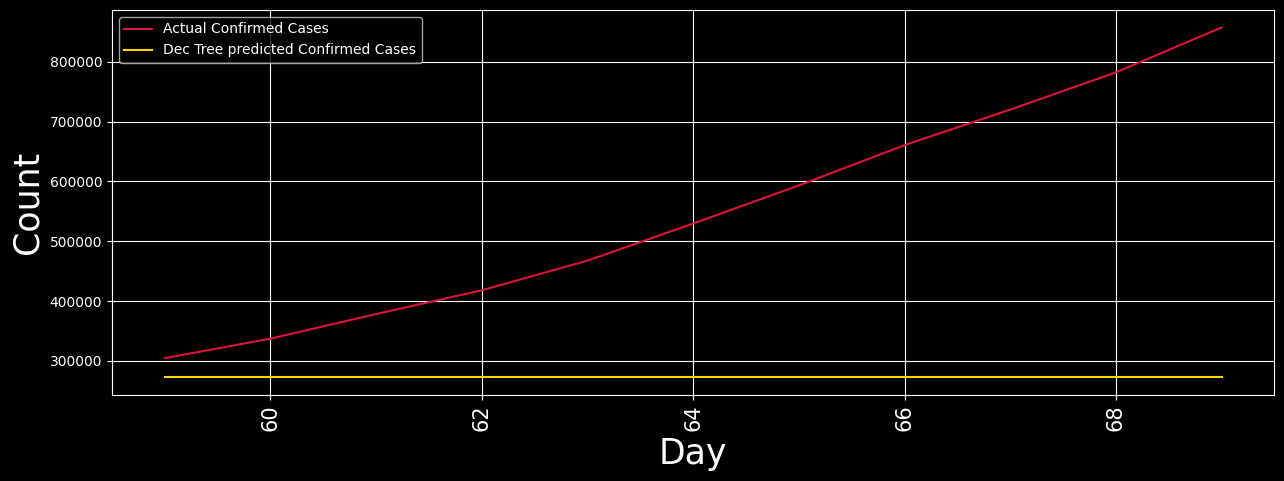

MAE: 277737.7272727273
MSE: 109079514439.72728


In [ ]:
plt.style.use("dark_background");
plt.figure(figsize = [15,5]);

# plotting the actual values for the future days
plt.plot(y_test,
         X_test,
         label = "Actual Confirmed Cases",
         color = 'crimson')

# plotting the predicited values for the future days
plt.plot(y_test,
         y_test_DT_pred,
         label = "Dec Tree predicted Confirmed Cases",
         color = 'gold')

plt.grid();
plt.legend();
plt.xlabel("Day", size = 25)
plt.ylabel("Count", size = 25)
plt.xticks(rotation = 90, size = 15);
plt.show()

print('MAE:', mean_absolute_error(y_test_DT_pred, X_test))
print('MSE:',mean_squared_error(y_test_DT_pred, X_test))

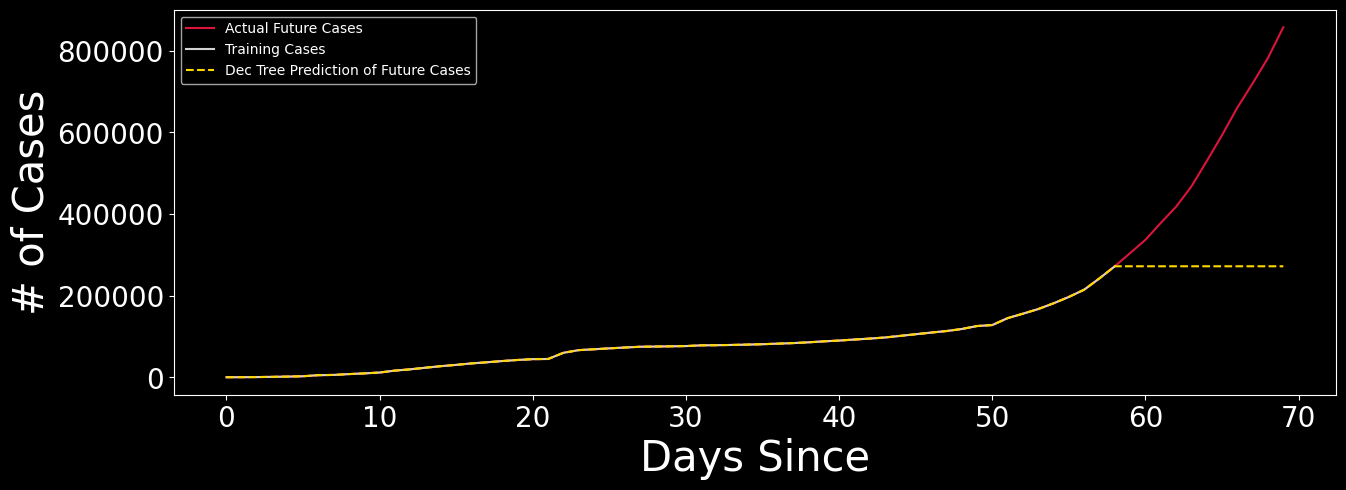

In [ ]:
plt.figure(figsize=(15, 5))

plt.plot(y,
         X,
         label = 'Actual Future Cases',
         color = 'crimson')

plt.plot(y_train,
         X_train,
         label = 'Training Cases',
         color = 'lightgrey')

plt.plot(y,
         y_DT_pred,
         label = 'Dec Tree Prediction of Future Cases',
         linestyle = "dashed",
         color = 'gold')

#plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Days Since', size = 30)
plt.ylabel('# of Cases', size = 30)
plt.legend()
plt.xticks(size=20)
plt.yticks(size=20)
plt.show()

## 10. Model Prediction Assessment

As can we see, all of the models underestimate the actual results, some is only slightly, while others have a much more prominent distinction. It seems that Polynomial Regression and Ridge Polynomial Regression were the best models in predicting the confirmed cases data.

In [ ]:
print("Polynomial Regression ")
print('\tMAE:', mean_absolute_error(test_linear_pred, X_test))
print('\tMSE:',mean_squared_error(test_linear_pred, X_test))

print("\nRidge Polynomial Regression ")
print ('\tMAE:', mean_absolute_error(test_poly_bayesian_pred, X_test))
print ('\tMSE:', mean_squared_error (test_poly_bayesian_pred, X_test))

Polynomial Regression 
	MAE: 31989.752428427022
	MSE: 1314905574.5277777

Ridge Polynomial Regression 
	MAE: 15796.104528765141
	MSE: 352565821.2177801


Because it has the lower Mean Absolute Error and Mean Squared Error, Ridge Polynomial Regression Model seems to be the best model.